# Animating Nitrogen Dioxide Satellite Data (NASA)

#### Requirements:
- Python (Anaconda recommended)
- IDE / Text editor that can handle Jupyter Notebooks
- Packages:
    - pandas
    - matplotlib
    - cartopy
    - numpy
    - lxml
    - tqdm

- System:
    - Tested on Windows but should work on Linux, too
    
#### Other:
Please note that it takes a while to download all of the data since each month is stored in a separate csv-file. \
The longest cell has a progress bar to help visualize progress.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from io import BytesIO
import gzip
import requests
import lxml
from matplotlib.colors import LogNorm
import matplotlib.animation as animation
import re
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm.notebook import tqdm

In [2]:
#folder that containts all the filenames, in this case we're looking at monthly Nitrogen dioxide data
#other datasets can be found by removing "AURA_NO2_M/"
folder = "https://neo.gsfc.nasa.gov/archive/csv/AURA_NO2_M/"
#get response for a request
r = requests.get(folder)
#reading html response to a Pandas DataFrame
names = pd.read_html(r.text, flavor="lxml")[0]["Name"].dropna()
names = names.drop(names.index[0])
#print filenames
print(names)

2      AURA_NO2_M_2012-01.CSV.gz
3      AURA_NO2_M_2012-02.CSV.gz
4      AURA_NO2_M_2012-03.CSV.gz
5      AURA_NO2_M_2012-04.CSV.gz
6      AURA_NO2_M_2012-05.CSV.gz
                 ...            
123    AURA_NO2_M_2022-02.CSV.gz
124    AURA_NO2_M_2022-03.CSV.gz
125    AURA_NO2_M_2022-04.CSV.gz
126    AURA_NO2_M_2022-05.CSV.gz
127    AURA_NO2_M_2022-06.CSV.gz
Name: Name, Length: 126, dtype: object


In [3]:
#the data doesn't come with coordinates so we'll make them ourselves
lon = np.concatenate([np.arange(180,360,1),np.arange(0,180,1)])
lat = np.arange(90, -90, -1)
ds_list = []
dates = []
#progressbar
with tqdm(total=len(names), colour="green") as pbar:
    #loop through all files
    for name in names:
        #link to a file
        url = folder+name
        #find the date with Regex
        res = re.search(r"_([0-9-]+)\.", name)
        if res:
            dates.append(res.groups()[0])
        else:
            #in case of a wrongly named file, the program doesn't crash but a placeholder date is appointed
            dates.append("????-??")
        #receive response to request
        r = requests.get(url)
        #read bytes-like data
        bytes_io = BytesIO(r.content)
        #exctract csv files
        with gzip.open(bytes_io, 'rt') as read_file:
            #csv to DataFrame
            df = pd.read_csv(read_file, index_col=False, header=None)
        #downsize data by taking every 10th or every 4th cell (alternatively take averages but this can be very slow)
        #note that some data can be at 1440x720 resolution instead of 3600x1800 so dims are checked
        if df.shape == (1800, 3600):
            df = df.iloc[::10, :]
            df = df[df.columns[::10]]
        else:
            df = df.iloc[::4, :]
            df = df[df.columns[::4]]
        #set new latitudes and longitudes
        df.index = lat
        df.columns = lon
        #replace fill value with NaN so that colorbar won't register it
        df = df.where(df != 99999.0, np.nan)
        ds_list.append(df)
        #update progress bar
        pbar.update(1)

  0%|          | 0/126 [00:00<?, ?it/s]

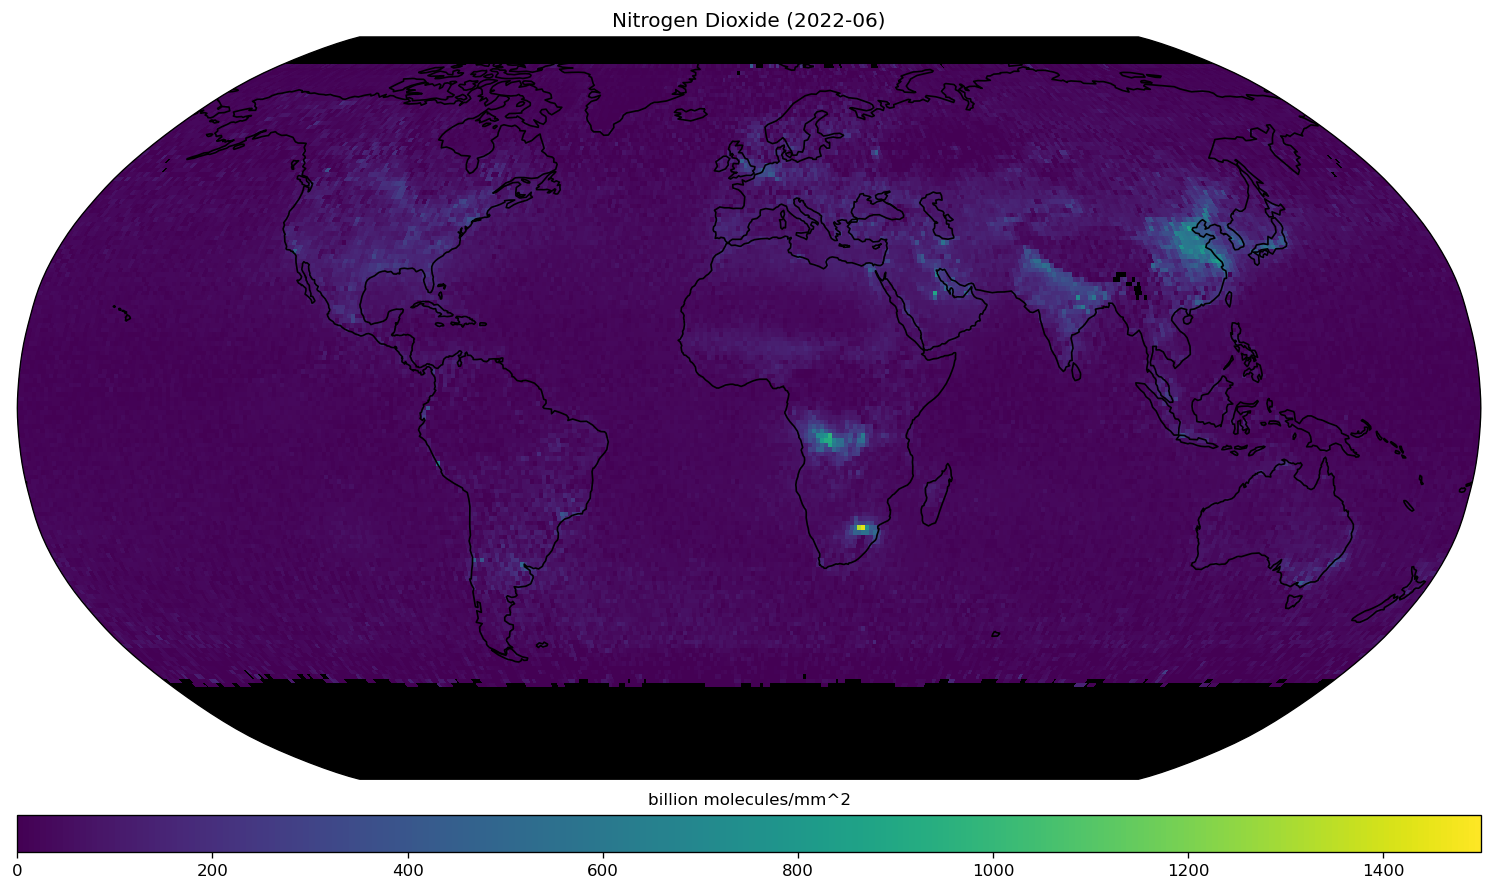

In [4]:
#set figure, facecolor helps to keep text nice
fig = plt.figure(facecolor="white", figsize=(16, 9), dpi=1920/16)
#set axes, preferred projection
ax = plt.axes(projection=ccrs.Robinson())
#global axes, coastlines to map
ax.set_global()
ax.coastlines()
#background color (will be visible if no data is present)
ax.patch.set_facecolor(color='black')
#title with each month
title = ax.set_title(f"Nitrogen Dioxide ({dates[0]})")
#data for first frame
data = ds_list[0]
#first frame (check norm if logarithmic scale!). Speficic color levels can also be set as a list or array after data
cs = ax.pcolormesh(lon, lat, data, transform=ccrs.PlateCarree(), cmap="viridis", shading='auto', animated=True)#, norm=LogNorm()) #can be used if data isn't linear 
#locatable axis -> easier to fit colorbar
divider = make_axes_locatable(ax)
#define axis for the colorbar
ax_cb = divider.new_vertical(size="5%", pad=0.3, axes_class=plt.Axes, pack_start=True)
#add axis
fig.add_axes(ax_cb)
#add colorbar
cb = fig.colorbar(cs, cax=ax_cb, orientation="horizontal")#ticks = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 60]) <- example ticks for logarithmic data
#title for colorbar
cb.ax.set_title('billion molecules/mm^2',fontsize=10)
#ticklabels for colorbar (default often ugly with log)
#cb.set_ticklabels(["0.01", "0.03", "0.1", "0.3", "1", "3", "10", "30", "60"])


#animation loop
def animate(i):
    #new values for colormesh
    cs.set_array(ds_list[i].values.ravel())
    #change title
    title.set_text(f"Nitrogen Dioxide ({dates[i]})")
    #return mesh and title each time
    return cs,title,

#create animation. Each month has own frame, interval between frames 200 ms
anim = animation.FuncAnimation(fig, animate, frames=len(ds_list), repeat=False, init_func=None, interval=200, blit=True)
#save product as an mp4 file
anim.save('NO2.mp4', writer=animation.FFMpegWriter())